# Sentiment analysis using complete self-attention


Author: **Rafael Ito**  
e-mail: ito.rafael@gmail.com

## 0. Dataset and Description

**Name:**  IMDb  
**Description:** this notebook uses the IMDb dataset which contains movie reviews classified as either positive or negative review. The aim is to perform a supervised learning for sentiment classification using as features the self-attention of the GloVe embeddings.

## 1. Libraries and packages

### 1.1 Install packages

In [0]:
!pip install -q \
    numpy       \
    torch       \
    sklearn     \
    skorch      \
    matplotlib  

### 1.2 Import libraries

In [2]:
#-------------------------------------------------
# general
#-------------------
import numpy as np
import pandas as pd
import nltk
import re
import os
import itertools
import collections
#-------------------------------------------------
# PyTorch
#-------------------
import torch
from torch.utils.data import TensorDataset
from torchtext.vocab import GloVe
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import Dropout
from torch.nn import LayerNorm
from torch.nn import Embedding
from torch.nn import Sequential
#-------------------------------------------------
# skorch
#-------------------
#from skorch import NeuralNetClassifier
#-------------------------------------------------
# scikit-learn
#-------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
#-------------------------------------------------
# data visualization
#-------------------
import matplotlib.pyplot as plt
import seaborn as sns
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
np.random.seed(42)
torch.manual_seed(42);

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.3 Check device

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('Device:', device)

Device: cuda


### 1.4 Constants definition

## 2. Custom functions and classes

### 2.1 Functions

Function that calculates the number of parameters of a network

In [0]:
'''
description:
    - given a model, this function returns its number of parameters (weight, bias)
#-------------------
positional args:
    - model [torch.nn.Module]: instance of the network
optional args:
    - verbose (default=False) [bool]: if True, print a report with the parameters of each layer
#-------------------
return:
    - [int] total parameters of the network
''';

In [0]:
def nparam(model, verbose=False):
    if(verbose):
        i = 0
        total = 0
        for name, param in model.named_parameters():
            if (param.requires_grad):
                #print('layer ', i, ' name: ', name)
                j = 1
                for dim in param.data.shape:
                    j = j * dim
                print('layer ', i, ': ', name, '; parameters: ', j, sep='')
                i += 1
                total += j
        print('total parameters = ', total)
        return
    else:
        #pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return sum(p.numel() for p in model.parameters())

Function to plot confusion matrix

In [0]:
'''
description:
    - this function plots the confusion matrix (normalized or not) 
    using Matplotlib and seaborn in a nice way using heatmap.
#-------------------
positional args:
    - confusion_matrix  [numpy.ndarray]:    ex.: array([[88, 19],[22, 71]])
    - class_names       [list of str]:      ex.: ['negative', 'positive']

optional args:
    - title     (default=None)          [str]:      title of the plot
    - normalize (default=False)         [bool]:     values raw or normalized
    - cmap      (default=plt.cm.Blues)     \
       [matplotlib.colors.LinearSegmentedColormap]: colormap to be used
    - fig_size   (default=(10,7))        [tuple]:    size of the figure
    - fontsize  (default=14)            [int]:      size of the text
#-------------------
return:
  - fig [matplotlib.figure.Figure]: confusion matrix plotted in a nice way!
''';

In [0]:
#https://github.com/ito-rafael/machine-learning/blob/master/snippets/confusion_matrix.py
def print_confusion_matrix(confusion_matrix, class_names, title=None, normalize=False, cmap=plt.cm.Blues, figsize = (10,7), fontsize=14):
    # normalized or raw CM
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    #----------------------------
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt, cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    #----------------------------
    # fix matplotlib 3.1.1 bug
    #heatmap.get_ylim() --> (5.5, 0.5)
    #heatmap.set_ylim(6.0, 0)
    #----------------------------
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Function that preprocess a document, returning the mean of word embeddings

In [0]:
'''
description:
    this function receives as parameter a corpus [list of lists] and do the following:
      - convert to lower case,
      - split in tokens,
      - remove stop words
return:
    the same corpus preprocessed
''';

In [0]:
def pre_processing(corpus, stopwords, embedding):
    corpus_pp = []
    for sentence in corpus:
        sentence = sentence.lower()                 # convert to lower case
        sentence = re.sub("[^\w]", " ",  sentence)  # match word characters [a-zA-Z0-9_]
        sentence = sentence.split()                 # split in tokens
        #---------------------------
        sentence_pp = []
        for token in sentence:
            # remove stop words
            if token not in stopwords: 
                sentence_pp.append(token)
        corpus_pp.append(sentence_pp)
    return corpus_pp

### 2.2 Classes

Class used for training in training loop

In [0]:
'''
description:
    this class is used during the training loop for TRAINING

parameters:
    - device
    - model
    - dataloader
    - loss_function
    - optimizer

return:
    np.mean(loss_his()) [numpy.float64]: mean of losses of all mini-batches in one epoch
    score_train.item()  [float]:         accuracy calculated over one epoch  
''';

In [0]:
class TrainingLoop():
    def __init__(self, device, model, dataloader, loss_function, optimizer):
        self.device = device
        self.model = model
        self.dataloader = dataloader
        self.loss_function = loss_function
        self.optimizer = optimizer

    def __call__(self):
        # training mode
        self.model.train()
        loss_his = np.zeros(len(self.dataloader))
        score_train = 0.
        for b_i, (b_x, b_y, b_m) in enumerate(self.dataloader):   # for each training step
            b_x, b_y, b_m = b_x.to(self.device), b_y.to(self.device), b_m.to(self.device)
            y_logitos = self.model(b_x, b_m)
            loss = self.loss_function(y_logitos, b_y)
            self.optimizer.zero_grad()  # clear gradients for next train
            loss.backward()             # backpropagation, compute gradients
            self.optimizer.step()        # apply gradients
            #-------------------
            y_pred = torch.argmax(y_logitos, dim=1)
            score_train += (b_y == y_pred).sum()
            loss_his[b_i] = loss.item()
        return np.mean(loss_his), score_train.item()

Class used for validation in training loop

In [0]:
'''
description:
    this class is used during the training loop for VALIDATION

parameters:
    - device
    - model
    - dataloader
    - loss_function

return:
    np.mean(loss_his()) [numpy.float64]: mean of losses of all mini-batches in one epoch
    score_valid.item()  [float]:         accuracy calculated over one epoch  
''';

In [0]:
class ValidatingLoop():
    def __init__(self, device, model, dataloader, loss_function):
        self.device = device
        self.model = model
        self.dataloader = dataloader
        self.loss_function = loss_function

    def __call__(self):
        # evaluation mode
        self.model.eval()
        loss_his = np.zeros(len(self.dataloader))
        score_valid = 0.
        for b_ival, (b_xval, b_yval, b_mval) in enumerate(self.dataloader):
            b_xval, b_yval, b_mval = b_xval.to(self.device), b_yval.to(self.device), b_mval.to(self.device)
            y_logitos = self.model(b_xval, b_mval)
            loss_valid = self.loss_function(y_logitos, b_yval)
            yval_pred = torch.argmax(y_logitos, dim=1)
            score_valid += (b_yval == yval_pred).sum()
            loss_his[b_ival] = loss_valid.item()
        return np.mean(loss_his), score_valid

## 3. Dataset Pre-processing

### 3.1 Download dataset

In [0]:
# # download partial dataset (1000 samples, 800 train, 200 test)
# !wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
# !tar -xzf imdb_sample.tgz

In [15]:
# download complete dataset (50k samples: 25k train, 25k test)
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz

File ‘aclImdb.tgz’ already there; not retrieving.



### 3.2 Download embeddings

In [0]:
# !wget -nc http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -o glove.6B.zip -d glove_dir

Loading word embeddings with gensin

In [17]:
 import gensim.downloader as api

 word2vec_model = api.load("glove-wiki-gigaword-300")
 print(word2vec_model.vectors.shape)
 print(word2vec_model.index2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loading word embeddings with torchtext

In [0]:
# from torchtext.vocab import GloVe
# word2vec_model = GloVe(name='6B', dim=EMBEDDING_DIM, cache='./glove_dir')
# #---------------------------
# print(word2vec_model.vectors.shape)
# print('First 20 words and its index:', list(word2vec_model.stoi.items())[:20])

In [19]:
word2vec_model['the'].shape

(300,)

### 3.3 Dataset loading

In [0]:
def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

load both classes

In [21]:
# load both classes
X_train_pos = load_texts('aclImdb/train/pos')
X_train_neg = load_texts('aclImdb/train/neg')
X_test_pos  = load_texts('aclImdb/test/pos')
X_test_neg  = load_texts('aclImdb/test/neg')
#---------------------------
# join positive and negative classes
X_train = X_train_pos + X_train_neg
X_test  = X_test_pos  + X_test_neg
y_train = [True] * len(X_train_pos) + [False] * len(X_train_neg)
y_test  = [True] * len(X_test_pos)  + [False] * len(X_test_neg)
#---------------------------
# print number of samples
print('train samples:', len(X_train))
print('test samples:', len(y_test))

train samples: 25000
test samples: 25000


training-validation split

In [22]:
# create validation set
X_valid = X_train[:2500] + X_train[-2500:]  # 2500 samples from positive class
y_valid = y_train[:2500] + y_train[-2500:]  # 2500 samples from negative class
#---------------------------
# remove them from training set
X_train = X_train[2500:-2500]
y_train = y_train[2500:-2500]
#---------------------------
print('train samples:', len(X_train))
print('valid samples:', len(X_valid))

train samples: 20000
valid samples: 5000


create vocabulary from word embedding

In [23]:
vocab = {word: index for index, word in enumerate(word2vec_model.index2word)}
#---------------------------
# adding the token 'PAD'
vocab['[PAD]'] = len(vocab)
pad_vector = np.zeros((1, word2vec_model.vectors.shape[1]))
embeddings = np.concatenate((word2vec_model.vectors, pad_vector), axis=0)
# convert embeddings from numpy to pytorch float32
embeddings = torch.from_numpy(embeddings)
embeddings = torch.tensor(embeddings, dtype=torch.float32)
#---------------------------
print('vocab size:', len(vocab))
print(f'20 most frequent tokens: {list(itertools.islice(vocab.keys(), 20))}')

vocab size: 400001
20 most frequent tokens: ['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


dataset tokenization and converting to index

In [0]:
# tokenize text, replace characters and convert to lower case
def tokenize(text):
    for char in ['"', '\'', '.', ',', ':', '-', '?', '!']:
        text = text.replace(char, ' ')
    return text.lower().split()
#---------------------------
# convert tokens to indexes
def tokens_to_ids(tokens, vocab):
    return [vocab[token] for token in tokens if token in vocab]
#---------------------------
# convert text in tokens, and then to indexes
def tokens_to_ids_batch(texts, vocab):
    return [tokens_to_ids(tokenize(text), vocab) for text in texts]

In [25]:
# get indexes of words in sentences
X_train_index = tokens_to_ids_batch(X_train, vocab)
X_test_index = tokens_to_ids_batch(X_test, vocab)
#---------------------------
# print first sentence and its indexes
print(X_train[0])
print(X_train_index[0])

I saw this movie, and the play, and I have to add that this was the most touching story that I had ever seen. Until I saw this movie I was unaware of how awful life was and probably still is for the South African children and adults that were and are living in that era. It brought tears to my eyes and much sadness to my heart that any human being should have to struggle like that just to stay alive, And to bring the children right out of that area and teach them to act and preform and turn them loose to tell their own story is simply amazing. This simply surpass a five star, I rate it a ten. Thank You Mr. Mbongeni Ngema for such a astonishing story. Although it has been 12 years since this story has been told, it is still one that lays heavy in my heart.If there is a VHS, or DVD out there on the play, Please notify me ASAP.Thank You. PS There was nothing wrong with the kids wanting to bring awareness of their problems and conditions to the attention of other countries in hopes that som

Converting word indexes in batches

In [0]:
def truncate_and_pad(batch_word_ids, pad_token_id, seq_length):
    #---------------------------
    # truncate
    batch_word_ids = [word_ids[:seq_length] for word_ids in batch_word_ids]
    #---------------------------
    # create mask
    mask = [
        [1] * len(word_ids) + [0] * (seq_length - len(word_ids))
        for word_ids in  batch_word_ids]
    #---------------------------
    # pad
    batch_word_ids = [
        word_ids + [pad_token_id] * (seq_length - len(word_ids))
        for word_ids in batch_word_ids]
    #---------------------------
    return batch_word_ids, mask

In [27]:
texts = ['we like pizza', 'he does not like apples']
batch_word_ids = tokens_to_ids_batch(texts, vocab)
batch, mask = truncate_and_pad(batch_word_ids=batch_word_ids,
                 pad_token_id=vocab['[PAD]'],
                 seq_length=8)
batch = np.array(batch)
mask = np.array(mask)
#---------------------------
for index in range(len(texts)):
    print('sentence: "', texts[index], '"', sep='')
    print('indexes:', batch_word_ids[index])
    print('mask:', mask[index], end='\n\n')

sentence: "we like pizza"
indexes: [53, 117, 9388]
mask: [1 1 1 0 0 0 0 0]

sentence: "he does not like apples"
indexes: [18, 260, 36, 117, 13134]
mask: [1 1 1 1 1 0 0 0]



In [28]:
# print shapes of batch and mask
print('batch.shape:', batch.shape)
print('mask.shape:', mask.shape)
print('batch:')
print(batch)

batch.shape: (2, 8)
mask.shape: (2, 8)
batch:
[[    53    117   9388 400000 400000 400000 400000 400000]
 [    18    260     36    117  13134 400000 400000 400000]]


### 3.4 PyTorch dataset creation

In [0]:
class ImdbDataset(torch.utils.data.Dataset):
    #def __init__(self, text, target, vocabulary, embeddings, seq_length=64):
    def __init__(self, text, target, vocabulary, seq_length=64):
        self.vocab = vocabulary
        self.seq_length = seq_length
        words_idx = tokens_to_ids_batch(text, self.vocab)
        self.X_str, mask = truncate_and_pad(
                            batch_word_ids=words_idx, 
                            pad_token_id=self.vocab['[PAD]'], 
                            seq_length=self.seq_length)
        self.X = torch.tensor(self.X_str, dtype=torch.int64)
        self.target = torch.tensor(target, dtype=torch.int64)
        self.mask = torch.tensor(mask, dtype=torch.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return (self.X[index], self.target[index], self.mask[index])

In [0]:
# dataset using Word Embeddings
ds_train = ImdbDataset(X_train, y_train, vocab, seq_length=128)
ds_valid = ImdbDataset(X_valid, y_valid, vocab, seq_length=128)
ds_test  = ImdbDataset(X_test,  y_test,  vocab, seq_length=128)

### 3.5 PyTorch loader creation

- BATCH_SIZE definition
- training dataset
- validation dataset

In [0]:
BATCH_SIZE = 100
#-------------------------------------------------
# training data loader
dl_train = torch.utils.data.DataLoader(
            dataset=ds_train, 
            drop_last = False,
            shuffle = True,
            batch_size = BATCH_SIZE)
#-------------------------------------------------
# validation data loader
dl_valid =  torch.utils.data.DataLoader(
            dataset = ds_valid,
            drop_last = False,
            shuffle = False,
            batch_size = BATCH_SIZE)

### 3.6 Verifying shape, batch data type from loader and optionally its visualization

In [32]:
tx, ty, _ = iter(dl_train).next()
print('train:', tx.shape, tx.dtype, ty.shape, ty.dtype)
tx, ty, _ = iter(dl_valid).next()
print('val:', tx.shape, tx.dtype, ty.shape, ty.dtype)
print('last batch size:', len(ds_train)%BATCH_SIZE, len(ds_valid)%BATCH_SIZE)

train: torch.Size([100, 128]) torch.int64 torch.Size([100]) torch.int64
val: torch.Size([100, 128]) torch.int64 torch.Size([100]) torch.int64
last batch size: 0 0


## 4. Network Model

### 4.1 Network layers definition

dimensions of tensors

In [33]:
V = len(vocab)
D = word2vec_model.vector_size
L = ds_train.seq_length
H = 6
B = BATCH_SIZE
#---------------------------
print('V =', V)     # vocab size
print('D =', D)     # embedding dim
print('H =', H)     # length of sequence
print('L =', L)     # number of heads
print('B =', B)     # batch size

V = 400001
D = 300
H = 6
L = 128
B = 100


Residual Layer

In [0]:
# class ResidualLayer(torch.nn.Module):
#     def __init__(self, layer):
#         self.layer = layer

#     def forward(self, x):
#         residual = x.clone()
#         x = self.layer(x)
#         x += residual
#         return x

Positional Embedding Layer

In [0]:
class PositionalEmbedding(torch.nn.Module):
    def __init__(self, L, D, device):
        super(PositionalEmbedding, self).__init__()
        self.L = L
        self.D = D
        self.device = device
        self.positions = torch.arange(self.L).to(device)
        self.layer = Embedding(num_embeddings=self.L, embedding_dim=self.D)

    def forward(self, x):
        return x + self.layer(self.positions)

In [0]:
# def own_layer_norm(self, x):
#     # x.shape = (B, L, D)
#     mean = x.mean(2)
#     std = x.std(2)
#     x = (x - mean) / (std + 1e-5)
#     #x = x * alpha + beta
#     return x

Multi-Head Attention Layer

In [0]:
def attention(q, k, v, D):
    k = k.transpose(2,3)
    self_attention = ((q @ k) / torch.sqrt(torch.tensor(D, dtype=torch.float32))) @ v
    return F.softmax(self_attention)

In [0]:
class MultiHead(torch.nn.Module):
    def __init__(self, L, D, H, B):
        super(MultiHead, self).__init__()
        self.L = L  # length of sequence
        self.D = D  # embedding dim
        self.H = H  # number of heads
        self.B = B  # batch size
        #---------------------------
        self.W_q = Linear(self.D, self.D, bias=False)
        self.W_k = Linear(self.D, self.D, bias=False)
        self.W_v = Linear(self.D, self.D, bias=False)
        self.W_o = Linear(self.D, self.D, bias=False)

    def forward(self, x):
        # multi-head (linear projections)
        q = self.W_q(x).view(self.B, self.L, self.H, int(self.D/self.H))
        k = self.W_k(x).view(self.B, self.L, self.H, int(self.D/self.H))
        v = self.W_v(x).view(self.B, self.L, self.H, int(self.D/self.H))
        # transpose to (H, L, D/H)
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        #-------------------
        new_x = attention(q, k, v, self.D)
        new_x = new_x.transpose(1, 2).contiguous()
        new_x = new_x.view(self.B, self.L, self.D)
        #-------------------
        # output linear projections
        return self.W_o(new_x)

Feed Forward Network Layer

In [0]:
class MLP2Layer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP2Layer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        #---------------------------
        self.hidden = Linear(in_features=self.input_size, out_features=self.hidden_size)
        self.output = Linear(in_features=self.hidden_size, out_features=self.output_size)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.output(x)
        return x

MLP Network Layer

In [0]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size
        #---------------------------
        self.hidden1 = Linear(in_features=self.input_size, out_features=self.hidden1_size)
        self.hidden2 = Linear(in_features=self.hidden1_size, out_features=self.hidden2_size)
        self.output = Linear(in_features=self.hidden2_size, out_features=self.output_size)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x

### 4.2 Network model definition

In [0]:
'''
V: vocabulary size
D: dimension of embeddings
H: number of heads in multi-head
L: legth of the sequence (number of words)
B: batch size
'''
class TransformerEncoder(torch.nn.Module):
    def __init__(self, D, L, H, B, idx2vec, device):
#    def __init__(self, D, L, H, device):
        super(TransformerEncoder, self).__init__()
        self.L = L  # length of sequence
        self.D = D  # embedding dim
        self.H = H  # number of heads
        self.B = B  # batch size
        self.device = device
        self.idx2vec = idx2vec.to(self.device)
        #-------------------------------------------------
        self.pos_emb = PositionalEmbedding(self.L, self.D, self.device)
        self.multihead = MultiHead(self.L, self.D, self.H, self.B)
        self.norm1 = LayerNorm(self.D)
        self.ffn = MLP2Layer(self.D, self.D, 1)
        self.norm2 = LayerNorm(self.D)
        self.mlp = MLP(self.D, 100, 100, 2)
#        self.dropout = Dropout(0.5)

    def forward(self, x, mask):
        #-------------------
        # get embeddings
        x = self.idx2vec[x]
        # sum with positional embeddings
        x = self.pos_emb(x)
        #-------------------
        # multi-head attention
        residual = x.clone()
        x = self.multihead(x)
        # add & norm
        x = x + residual
        x = self.norm1(x)
        #-------------------
        # feed forward
        residual = x.clone()
        x = self.ffn(x)
        # add & norm
        x = x + residual
        x = self.norm1(x)
        #-------------------
        # masked mean
        x = x * mask.reshape(self.B, -1, 1)
        #seq_len = torch.nonzero(mask).size(0)
        seq_len = L - (batch_m == 0).sum(dim=1)
        seq_len = seq_len.reshape(-1,1)
        x = (torch.sum(x, dim=1) / seq_len)
        #-------------------
        # final mlp
        x = self.mlp(x)
        return x

### 4.3 Network instantiation

In [42]:
model = TransformerEncoder(D, L, H, B, embeddings, device)
model.to(device)

TransformerEncoder(
  (pos_emb): PositionalEmbedding(
    (layer): Embedding(128, 300)
  )
  (multihead): MultiHead(
    (W_q): Linear(in_features=300, out_features=300, bias=False)
    (W_k): Linear(in_features=300, out_features=300, bias=False)
    (W_v): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=300, out_features=300, bias=False)
  )
  (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (ffn): MLP2Layer(
    (hidden): Linear(in_features=300, out_features=300, bias=True)
    (output): Linear(in_features=300, out_features=1, bias=True)
  )
  (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (hidden1): Linear(in_features=300, out_features=100, bias=True)
    (hidden2): Linear(in_features=100, out_features=100, bias=True)
    (output): Linear(in_features=100, out_features=2, bias=True)
  )
)

### 4.4 Network predict with few samples of batch from loader

In [0]:
# single dataset sample in GPU
#model(ds_train[0][0].to(device), ds_train[0][2].to(device))
#model(ds_train[0][0].unsqueeze(dim=-1).to(device), ds_train[0][2].unsqueeze(dim=-1).to(device))

In [44]:
# batch sample using dataloader in GPU
batch_x, batch_y, batch_m = iter(dl_train).next()
batch_x, batch_y, batch_m = batch_x.to(device), batch_y.to(device), batch_m.to(device)
model(batch_x, batch_m);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


## 5. Network training

### 5.1 Training definitions

- number of epochs
- optimizer and LR (learning rate)
- loss function


In [0]:
# Training parameters
EPOCH = 100
LR = 0.00005
PATIENCE = 5
loss_func = torch.nn.CrossEntropyLoss()
#opt = torch.optim.SGD(model.parameters(), lr=LR)
opt = torch.optim.Adam(model.parameters(), lr=LR)
#-------------------
best_valid_loss = 999_999.
train_samples = len(ds_train)
valid_samples = len(ds_valid)
#-------------------
trainer = TrainingLoop(device, model, dl_train, loss_func, opt)
validator = ValidatingLoop(device, model, dl_valid, loss_func)
#-------------------
# loss history
loss_train_his = []
loss_valid_his = []
acc_train_his = []
acc_valid_his = []

### 5.2 Training loop

In [46]:
%%time
for epoch in range(EPOCH):
    # training
    his_train = trainer()
    loss_train_his.append(his_train[0])
    acc_train_his.append(his_train[1] / train_samples)
    #-------------------
    # validating
    his_valid = validator()
    loss_valid_his.append(his_valid[0])
    acc_valid_his.append(his_valid[1] / valid_samples)
    #-------------------------------------------------
    # early stopping: check if new validation accuracy occurred
    if loss_valid_his[-1] < best_valid_loss:
        # print('New best loss in validation set!', end=' ')
        best_valid_loss = loss_valid_his[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter == PATIENCE:
            print('Early stopping:', PATIENCE, 'iterations without validation loss improve')
            break
    #-------------------------------------------------
    if not (epoch % 1):
        print('epoch =', epoch, end='; ')
        print('loss_train = {0:.4f}'.format(loss_train_his[-1]), end='; ')
        print('loss_val = {0:.4f}'.format(loss_valid_his[-1]), end='; ')
        print('acc_train = {0:.4f}'.format(acc_train_his[-1]), end='; ')
        print('acc_val = {0:.4f}'.format(acc_valid_his[-1]), end='\n')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


epoch = 0; loss_train = 0.6859; loss_val = 0.6648; acc_train = 0.5865; acc_val = 0.6618
epoch = 1; loss_train = 0.6111; loss_val = 0.5394; acc_train = 0.6947; acc_val = 0.7610
epoch = 2; loss_train = 0.5147; loss_val = 0.4937; acc_train = 0.7627; acc_val = 0.7670
epoch = 3; loss_train = 0.4869; loss_val = 0.5073; acc_train = 0.7783; acc_val = 0.7616
epoch = 4; loss_train = 0.4758; loss_val = 0.4739; acc_train = 0.7882; acc_val = 0.7840
epoch = 5; loss_train = 0.4608; loss_val = 0.4590; acc_train = 0.7944; acc_val = 0.7892
epoch = 6; loss_train = 0.4533; loss_val = 0.4759; acc_train = 0.8015; acc_val = 0.7784
epoch = 7; loss_train = 0.4450; loss_val = 0.4536; acc_train = 0.8050; acc_val = 0.7924
epoch = 8; loss_train = 0.4404; loss_val = 0.4497; acc_train = 0.8092; acc_val = 0.7910
epoch = 9; loss_train = 0.4336; loss_val = 0.4734; acc_train = 0.8116; acc_val = 0.7800
epoch = 10; loss_train = 0.4277; loss_val = 0.4503; acc_train = 0.8118; acc_val = 0.7966
epoch = 11; loss_train = 0.4236

## 6. Training evaluation

- metrics:
  - accuracy
  - confusion matrix
  - others

### 6.1 Training and Validation Losses

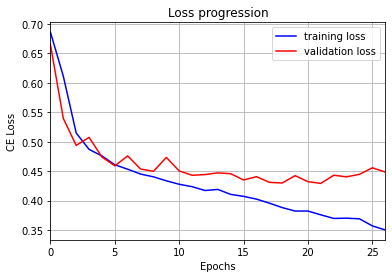

In [47]:
# plot training and validation loss
plt.plot(loss_train_his, label='training loss', color='blue')
plt.plot(loss_valid_his, label='validation loss', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('CE Loss')
# title
plt.title('Loss progression')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
plt.legend() # add legend
plt.show()

### 6.2 Zoom at the minimum CE loss in the validation loss curve

Epoch with minimum validation loss = 22


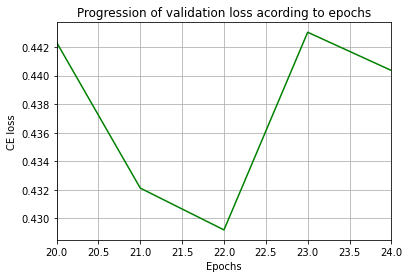

In [48]:
BEST_EPOCH = loss_valid_his.index(min(loss_valid_his)) + 1
print('Epoch with minimum validation loss =', BEST_EPOCH)
#-------------------------------------------------
# plots
plt.plot(range(max(1,BEST_EPOCH-2),min(EPOCH,BEST_EPOCH+3)), loss_valid_his[max(1,BEST_EPOCH-3):min(EPOCH-1,BEST_EPOCH+2)], 'green')
plt.xlabel('Epochs')
plt.ylabel('CE loss')
plt.autoscale(axis='x', tight=True)
plt.title('Progression of validation loss acording to epochs')
plt.grid(True)
plt.show()

### 6.3 Accuracy 

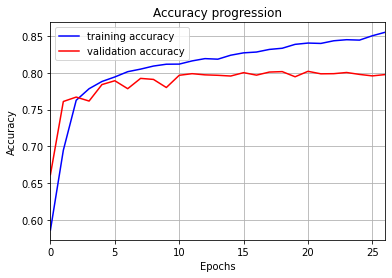

In [49]:
# plot training and validation accuracy
plt.plot(acc_train_his, label='training accuracy', color='blue')
plt.plot(acc_valid_his, label='validation accuracy', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# title
plt.title('Accuracy progression')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
plt.legend() # add legend
plt.show()

### 6.4 Print the final values of the main training monitoring variables:
- loss function final value:
- metrics final values:

In [50]:
print('last training loss = {0:.4f}'.format(loss_train_his[-1]))
print('last validation loss = {0:.4f}'.format(loss_valid_his[-1]))
print('#-------------------------------------------------')
print('last train accuracy = {0:.4f}'.format(acc_train_his[-1]))
print('last validation accuracy = {0:.4f}'.format(acc_valid_his[-1]))

last training loss = 0.3502
last validation loss = 0.4485
#-------------------------------------------------
last train accuracy = 0.8551
last validation accuracy = 0.7976


## 7. Metrics on test set

For this particular dataset, we will be using the validation set to calculate the performance metrics

In [0]:
# test data loader
dl_test =  torch.utils.data.DataLoader(
            dataset = ds_test,
            drop_last = False,
            shuffle = False,
            batch_size = BATCH_SIZE)

In [0]:
# save model parameters
PATH = '/content/model_parameters'
torch.save(model.state_dict(), PATH)

In [0]:
# create a new model
model_test = TransformerEncoder(D, L, H, B, embeddings, device)

In [54]:
# load in new network instance
model_test.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [55]:
# load model in CPU
model_test.to(device);
# evaluation mode
model_test.eval()

TransformerEncoder(
  (pos_emb): PositionalEmbedding(
    (layer): Embedding(128, 300)
  )
  (multihead): MultiHead(
    (W_q): Linear(in_features=300, out_features=300, bias=False)
    (W_k): Linear(in_features=300, out_features=300, bias=False)
    (W_v): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=300, out_features=300, bias=False)
  )
  (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (ffn): MLP2Layer(
    (hidden): Linear(in_features=300, out_features=300, bias=True)
    (output): Linear(in_features=300, out_features=1, bias=True)
  )
  (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (hidden1): Linear(in_features=300, out_features=100, bias=True)
    (hidden2): Linear(in_features=100, out_features=100, bias=True)
    (output): Linear(in_features=100, out_features=2, bias=True)
  )
)

Evaluation

In [0]:
y_true = ds_test[:][1]
y_pred = []

In [57]:
%%time
# evaluation
loss_his_test = np.zeros(len(dl_test))
score_test = 0.
for b_itest, (b_xtest, b_ytest, b_mtest) in enumerate(dl_test):
    b_xtest, b_ytest, b_mtest = b_xtest.to(device), b_ytest.to(device), b_mtest.to(device)
    y_logitos = model_test(b_xtest, b_mtest)
    loss_test = loss_func(y_logitos, b_ytest)
    ytest_pred = torch.argmax(y_logitos, dim=1)
    y_pred.append(ytest_pred)
    score_test += (b_ytest == ytest_pred).sum()
    loss_his_test[b_itest] = loss_test.item()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


CPU times: user 1.01 s, sys: 366 ms, total: 1.38 s
Wall time: 1.37 s


### 7.1 Accuracy

In [58]:
# accuracy
acc_test = score_test / len(ds_test)
acc_test.item()

0.8005200028419495

In [0]:
# concatenate batch
y_pred = torch.cat(y_pred)
# move tensors back to cpu
y_true = y_true.to('cpu')
y_pred = y_pred.to('cpu')

### 7.2 Confusion matrix

In [0]:
cm = confusion_matrix(y_true, y_pred)
#classes = enc.get_feature_names()
classes = ['negative', 'positive']

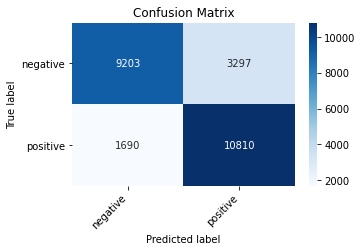

In [61]:
# CM raw
cm_raw = print_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=False, cmap=plt.cm.Blues, fontsize=10, figsize = (5,3))

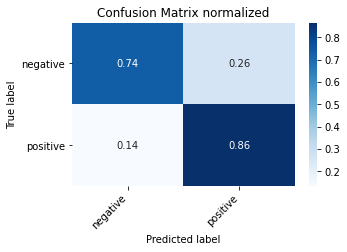

In [62]:
# CM normalized
cm_norm = print_confusion_matrix(cm, classes, title='Confusion Matrix normalized', normalize=True, cmap=plt.cm.Blues, fontsize=10, figsize = (5,3))

### 7.3 F1-score (macro, micro and weighted)

In [0]:
macro = f1_score(y_true, y_pred, average='macro')
micro = f1_score(y_true, y_pred, average='micro')
weighted = f1_score(y_true, y_pred, average='weighted')

In [64]:
print('F1-score macro =', macro)
print('F1-score micro =', micro)
print('F1-score weighted =', weighted)

F1-score macro = 0.7996923451151203
F1-score micro = 0.80052
F1-score weighted = 0.7996923451151204


### 7.4 Accuracy and Precision

In [0]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')

In [66]:
print('Accuracy score = ', acc, sep='')
print('Precision score = ', prec, sep='')

Accuracy score = 0.80052
Precision score = 0.8055703672924416


### 7.5 Precision, Recall and F1-Score for each class

In [67]:
from sklearn.metrics import classification_report as cr
print(cr(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79     12500
           1       0.77      0.86      0.81     12500

    accuracy                           0.80     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.80      0.80     25000



## 8. Number of parameters

In [68]:
nparam(model, verbose=True)

layer 0: pos_emb.layer.weight; parameters: 38400
layer 1: multihead.W_q.weight; parameters: 90000
layer 2: multihead.W_k.weight; parameters: 90000
layer 3: multihead.W_v.weight; parameters: 90000
layer 4: multihead.W_o.weight; parameters: 90000
layer 5: norm1.weight; parameters: 300
layer 6: norm1.bias; parameters: 300
layer 7: ffn.hidden.weight; parameters: 90000
layer 8: ffn.hidden.bias; parameters: 300
layer 9: ffn.output.weight; parameters: 300
layer 10: ffn.output.bias; parameters: 1
layer 11: norm2.weight; parameters: 300
layer 12: norm2.bias; parameters: 300
layer 13: mlp.hidden1.weight; parameters: 30000
layer 14: mlp.hidden1.bias; parameters: 100
layer 15: mlp.hidden2.weight; parameters: 10000
layer 16: mlp.hidden2.bias; parameters: 100
layer 17: mlp.output.weight; parameters: 200
layer 18: mlp.output.bias; parameters: 2
total parameters =  530603


## End of the notebook